In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [2]:
df = pd.read_csv('housing.csv')

# 1. Exploratory Data Analysis (EDA)

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(f"Rows: {dataframe.shape[0]}")
    print(f"Columns: {dataframe.shape[1]}")

    print("\n##################### Types #####################")
    print(dataframe.dtypes)

    print("\n##################### Head #####################")
    print(dataframe.head(head))

    print("\n##################### Tail #####################")
    print(dataframe.tail(head))

    print("\n##################### NA #####################")
    print(dataframe.isnull().sum())

    print("\n##################### Quantiles #####################")
    print(dataframe.describe().T)

In [4]:
check_df(df)

##################### Shape #####################
Rows: 20640
Columns: 10

##################### Types #####################
longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

##################### Head #####################
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value

In [5]:
# Checking for duplicates

def check_duplicates(dataframe):
    duplicates = dataframe[dataframe.duplicated()]
    if duplicates.shape[0] == 0:
        print("No duplicate rows found in the DataFrame.")
    else:
        print("Total {} duplicate rows found in the DataFrame.".format(duplicates.shape[0]))
        print("Duplicate rows:")
        print(duplicates)

In [6]:
check_duplicates(df)

No duplicate rows found in the DataFrame.


In [7]:
##################################################
# Capturing numerical and Categorical variables 
##################################################

# This function analyzes the columns in a dataframe and determines categorical, numerical, and other columns.

def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() >= car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 20640
Variables: 10
cat_cols: 1
num_cols: 9
cat_but_car: 0
num_but_cat: 0


In [9]:
cat_cols

['ocean_proximity']

In [10]:
#########################################
# Analysis of Categorical Variables
#########################################

# This function performs the analysis and visualization of categorical variables.

def cat_summary(dataframe, col_name, plot=True):

    value_counts = dataframe[col_name].value_counts()
    ratio = 100 * value_counts / len(dataframe)
    
    if plot:
        plt.figure(figsize=(8, 4))
        sns.countplot(y=dataframe[col_name], data=dataframe, order=value_counts.index)
        plt.title(f"{col_name} Distribution")
        plt.xlabel("Count")
        plt.ylabel(col_name)
        plt.xticks(rotation=0)
        
        for i, v in enumerate(value_counts.values):
            plt.text(v + 1, i, f"{v} ({ratio.iloc[i]:.2f}%)", va='center')
        
        plt.show()

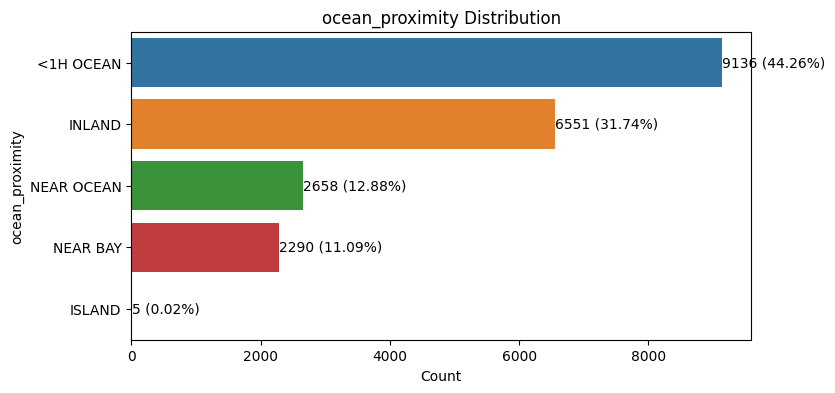

In [11]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [12]:
########################################
# Analysis of Numerical Variables
########################################

# This function performs the analysis of numerical variables and, if desired, visualizes them.

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary = dataframe[numerical_col].describe(quantiles)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        
        # Plot histogram
        dataframe[numerical_col].hist(bins=20, ax=axes[0], color="lightgreen")
        axes[0].set_xlabel(numerical_col)
        axes[0].set_title(numerical_col)
        
        # Displaying summary statistics as text
        summary_text = "\n".join([f'{col}: {value:.3f}' for col, value in summary.items()])
        axes[1].text(0.5, 0.5, summary_text, fontsize=12, va='center', ha='left', linespacing=1.5)
        axes[1].axis('off')  
        
        plt.show()
        print("################################################################")

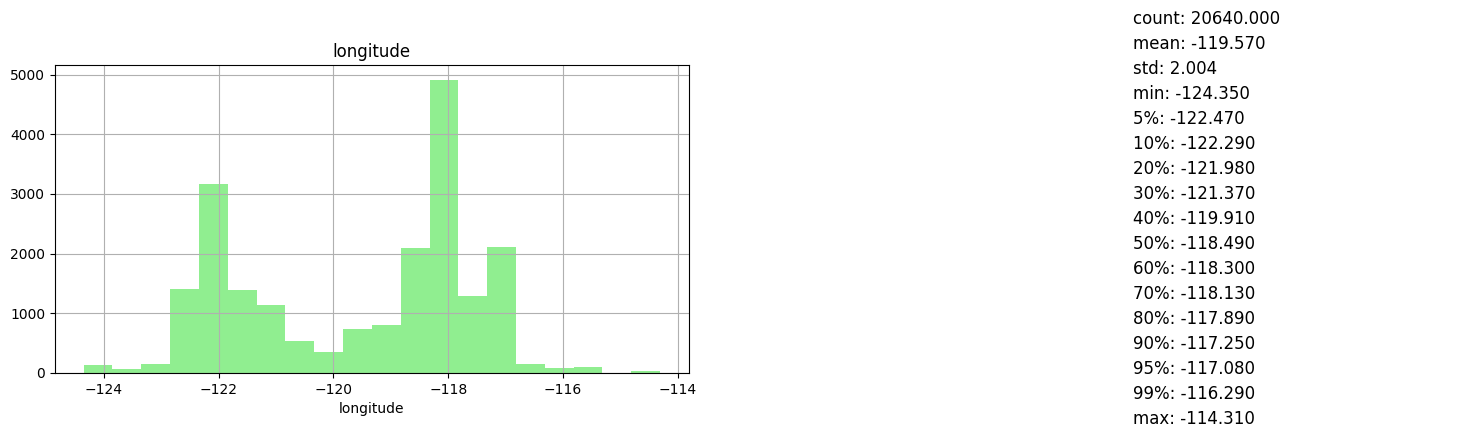

################################################################


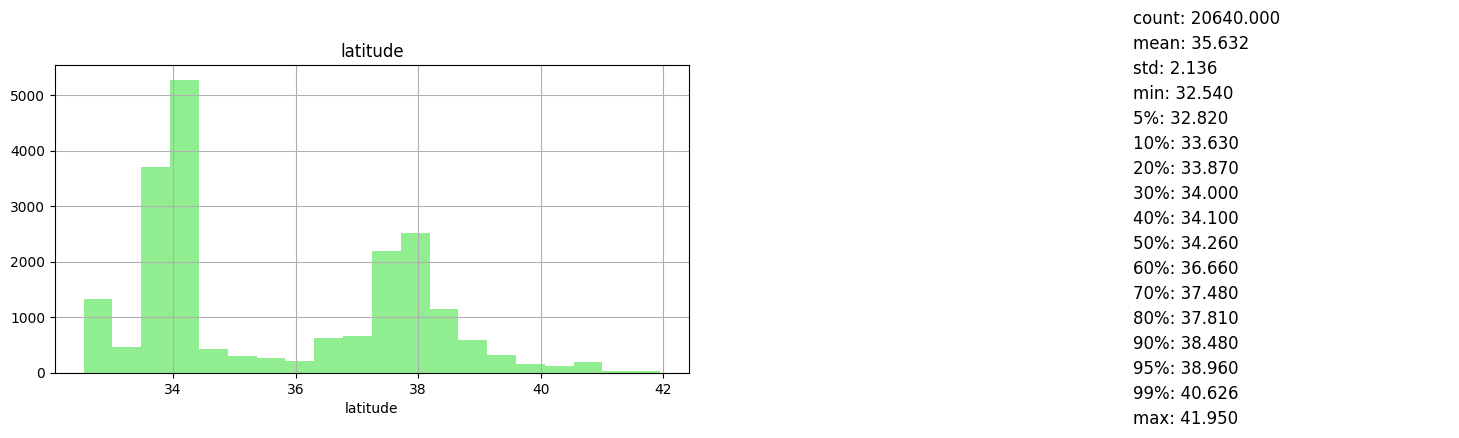

################################################################


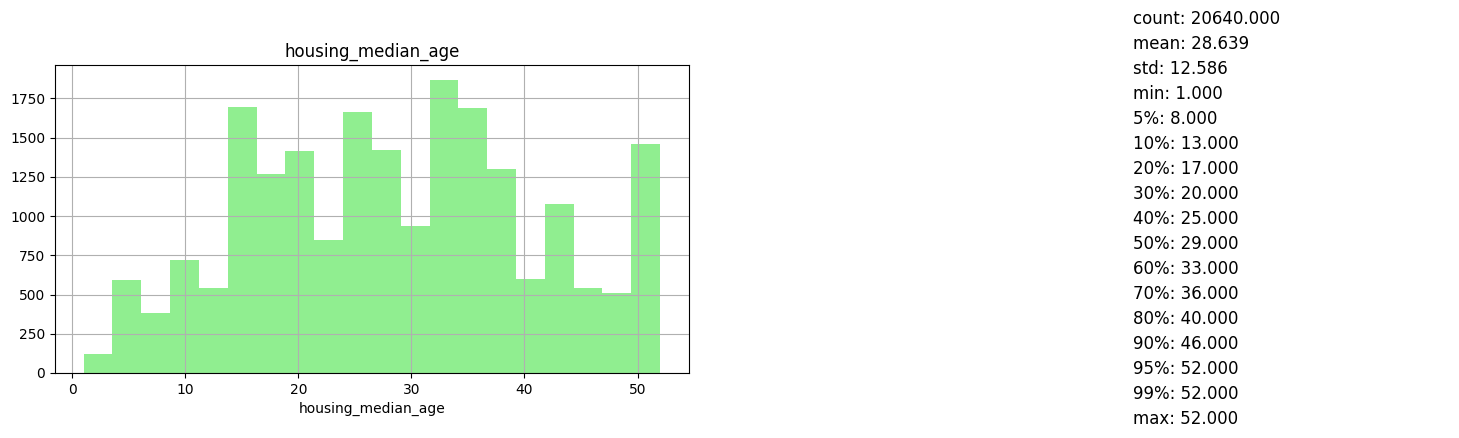

################################################################


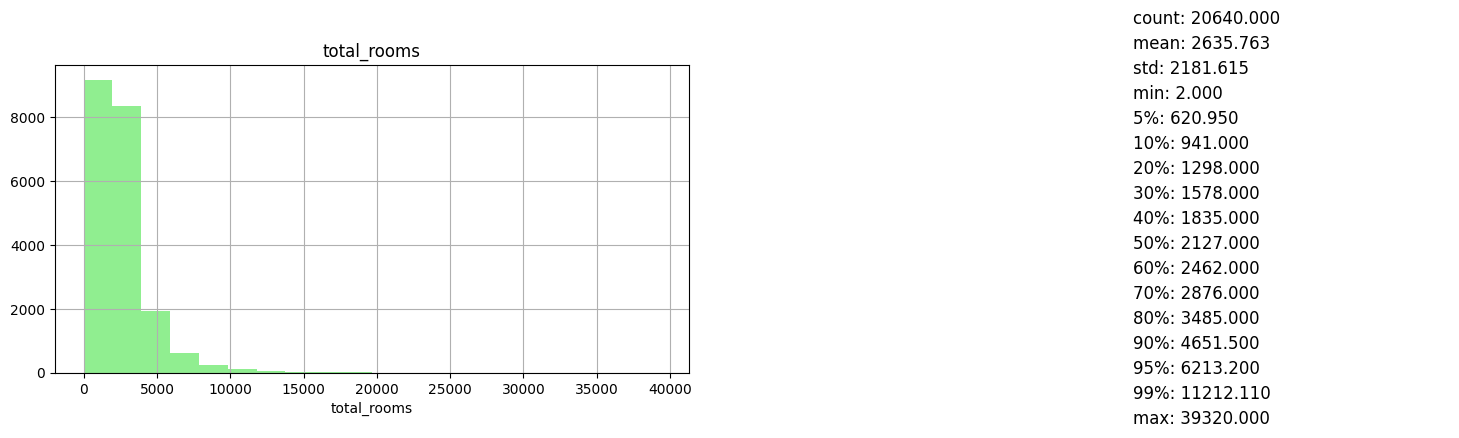

################################################################


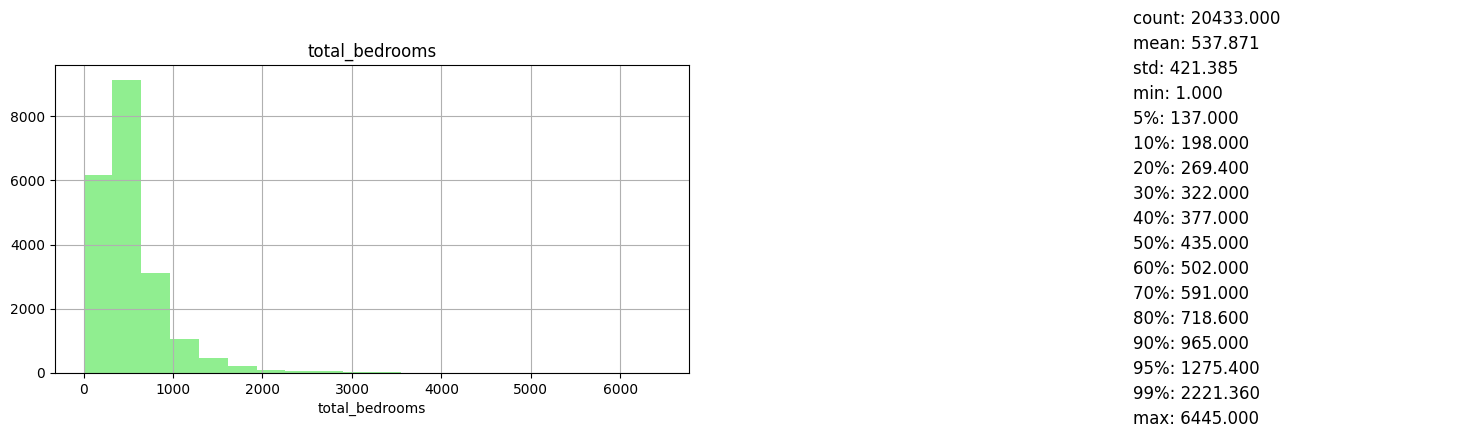

################################################################


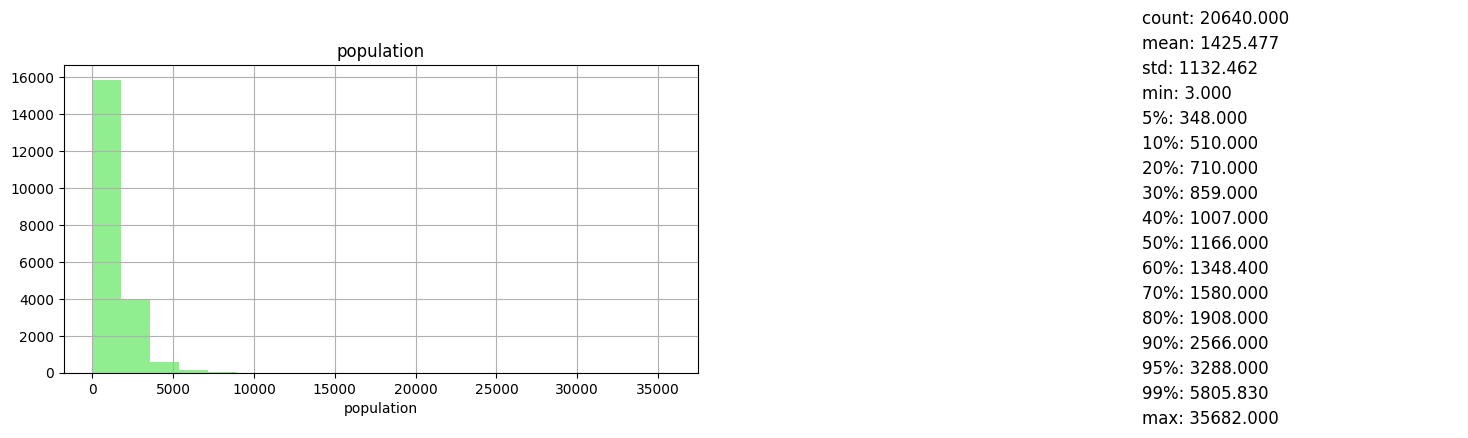

################################################################


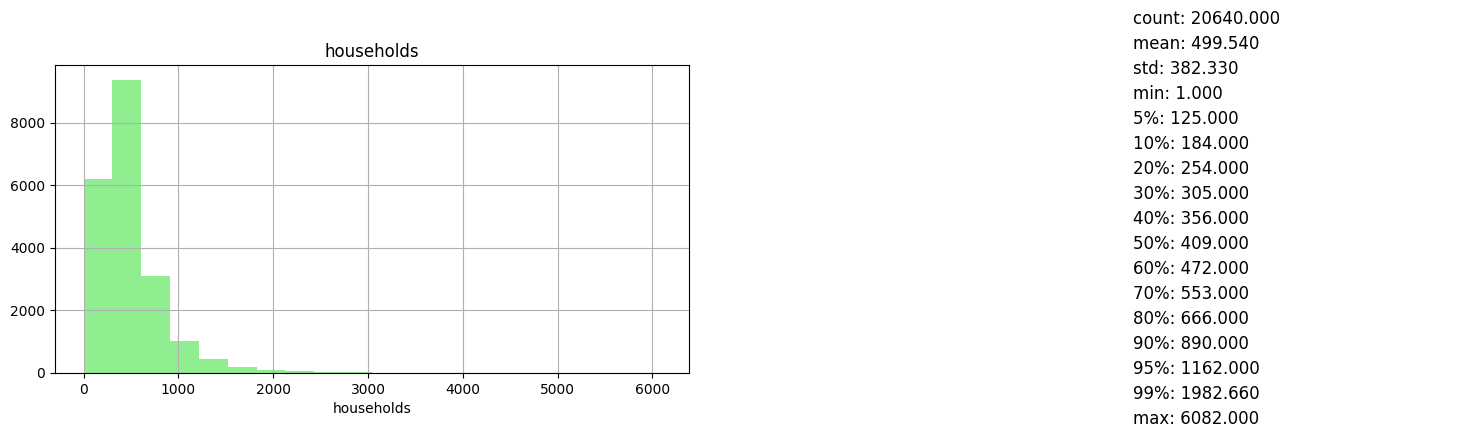

################################################################


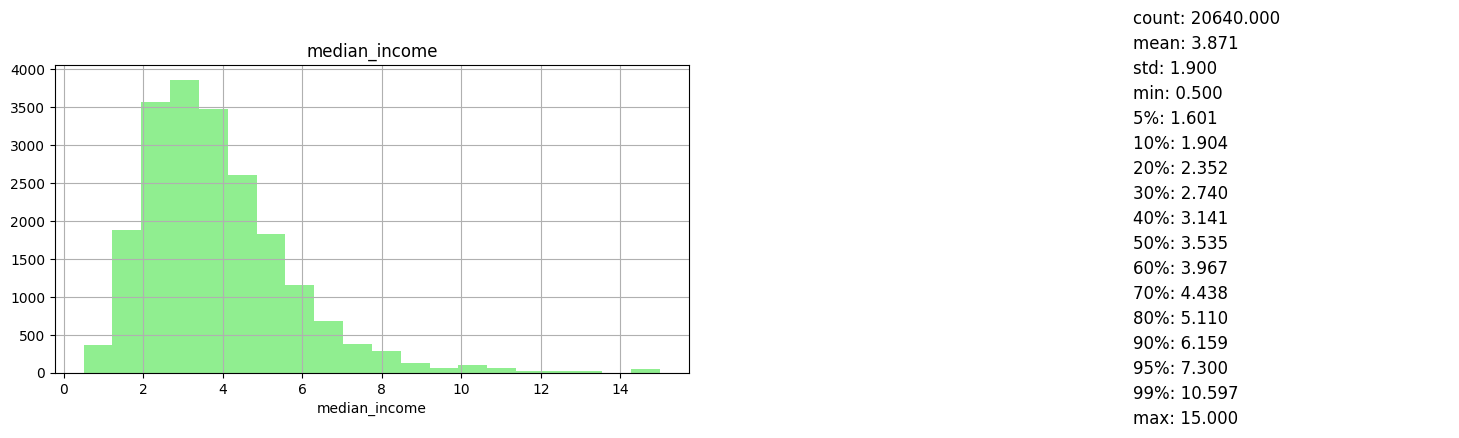

################################################################


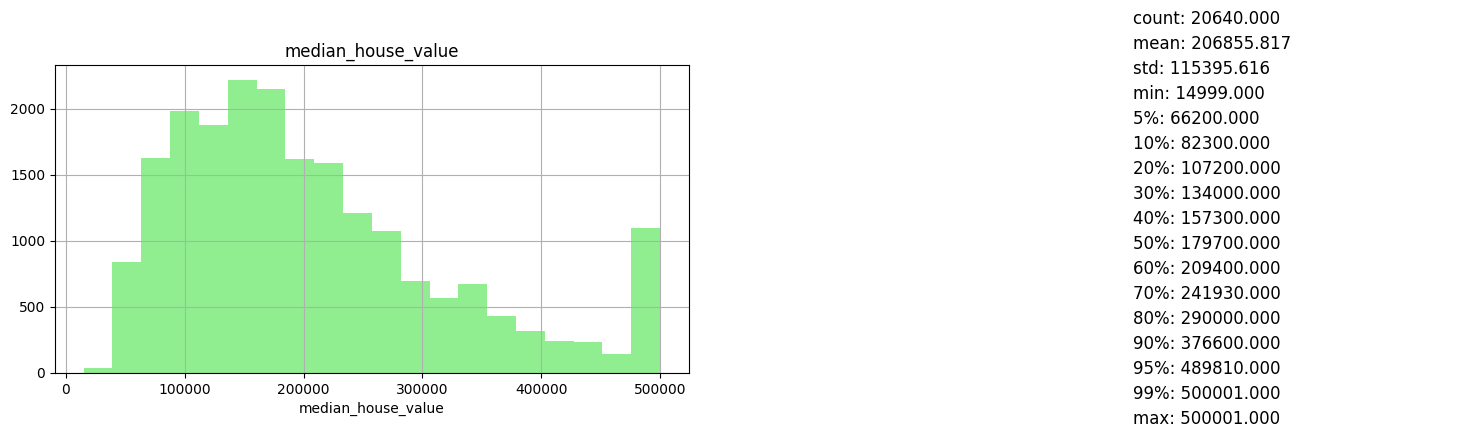

################################################################


In [13]:
for col in num_cols:
    num_summary(df, col, plot=True) 

### Preparing the dataset 

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [14]:
df= df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [15]:
df.shape

(15687, 10)

In [16]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [17]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [18]:
df['median_house_value'] = np.log1p(df.median_house_value)

In [19]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [20]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [21]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [22]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [23]:
df_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-120.25,37.93,13.0,493.0,76.0,196.0,68.0,3.3750,INLAND
1,-118.40,34.00,10.0,1526.0,339.0,705.0,268.0,5.8083,<1H OCEAN
2,-121.67,38.85,46.0,645.0,131.0,410.0,122.0,1.7417,INLAND
3,-118.14,33.88,24.0,3305.0,982.0,2085.0,881.0,2.6641,<1H OCEAN
4,-118.11,33.92,34.0,1414.0,263.0,983.0,264.0,4.1767,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
9406,-118.00,34.12,37.0,1340.0,325.0,928.0,333.0,3.9219,INLAND
9407,-118.10,34.10,34.0,2578.0,645.0,1628.0,617.0,2.3400,<1H OCEAN
9408,-117.45,34.01,26.0,3042.0,598.0,1720.0,551.0,2.7600,INLAND
9409,-117.94,34.03,35.0,1375.0,249.0,1015.0,239.0,4.0521,<1H OCEAN


In [24]:
# Turn the dataframes into matrices

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

In [25]:
X_train

<9411x10 sparse matrix of type '<class 'numpy.float64'>'
	with 84699 stored elements in Compressed Sparse Row format>

In [26]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [27]:
model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [28]:
print(export_text(model, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



- **ocean_proximity**

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [29]:
rf_model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [30]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
y_pred = rf_model.predict(X_val)

In [32]:
rmse = mean_squared_error(y_val, y_pred, squared=False).round(3)

print("The RMSE of the Random Forest model on validation is:", rmse)

The RMSE of the Random Forest model on validation is: 0.245


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160

In [33]:
n_estimators_values = list(range(10, 201, 10))

In [34]:
best_rmse = float('inf')
best_n_estimators = None

for n_estimators in n_estimators_values:
    
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_n_estimators = n_estimators

print("The best n_estimators value with the lowest RMSE is:", best_n_estimators)

The best n_estimators value with the lowest RMSE is: 170


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [35]:
max_depth_values = [10, 15, 20, 25]

In [36]:
best_mean_rmse = float('inf')
best_max_depth = None

for max_depth in max_depth_values:
    rmse_values = [] 
    
    for n_estimators in n_estimators_values:
        rf_model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=1, n_jobs=-1)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_val)
        
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_values.append(rmse)
    
    mean_rmse = np.mean(rmse_values)
    
    if mean_rmse < best_mean_rmse:
        best_mean_rmse = mean_rmse
        best_max_depth = max_depth

print("The best max_depth based on mean RMSE is:", best_max_depth)

The best max_depth based on mean RMSE is: 25


# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [38]:
rf_model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [42]:
feature_importances = rf_model.feature_importances_

In [43]:
feature_importance_dict = dict(zip(dv.feature_names_, feature_importances))

In [44]:
most_important_feature = max(feature_importance_dict, key=feature_importance_dict.get)

print("The most important feature is:", most_important_feature)

The most important feature is: median_income


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [46]:
features = dv.feature_names_
features = [f.replace("<", "less") for f in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [47]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [48]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [49]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:8.07362	val-rmse:8.07348
[5]	train-rmse:1.38983	val-rmse:1.38852
[10]	train-rmse:0.33195	val-rmse:0.34802
[15]	train-rmse:0.22197	val-rmse:0.25614
[20]	train-rmse:0.20036	val-rmse:0.24508
[25]	train-rmse:0.18991	val-rmse:0.24021
[30]	train-rmse:0.18204	val-rmse:0.23833
[35]	train-rmse:0.17091	val-rmse:0.23452
[40]	train-rmse:0.16422	val-rmse:0.23379
[45]	train-rmse:0.15756	val-rmse:0.23302
[50]	train-rmse:0.15210	val-rmse:0.23262
[55]	train-rmse:0.14633	val-rmse:0.23167
[60]	train-rmse:0.14218	val-rmse:0.23160
[65]	train-rmse:0.13898	val-rmse:0.23169
[70]	train-rmse:0.13471	val-rmse:0.23108
[75]	train-rmse:0.13072	val-rmse:0.23036
[80]	train-rmse:0.12835	val-rmse:0.23045
[85]	train-rmse:0.12534	val-rmse:0.23010
[90]	train-rmse:0.12174	val-rmse:0.22957
[95]	train-rmse:0.11894	val-rmse:0.22906
[99]	train-rmse:0.11656	val-rmse:0.22897


In [50]:
y_pred = model.predict(dval)

In [51]:
y_pred

array([12.136063, 12.115129, 11.55087 , ..., 11.960862, 11.147743,
       11.804589], dtype=float32)

In [52]:
rmse_eta_0_3 = mean_squared_error(y_val, y_pred, squared=False)
print("RMSE with eta=0.3:", rmse_eta_0_3)

RMSE with eta=0.3: 0.22897404244864047


In [53]:
# for eta=0.1

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [54]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:10.37456	val-rmse:10.37545
[5]	train-rmse:6.13433	val-rmse:6.13236
[10]	train-rmse:3.63299	val-rmse:3.62939
[15]	train-rmse:2.15901	val-rmse:2.15616
[20]	train-rmse:1.29412	val-rmse:1.29329
[25]	train-rmse:0.78993	val-rmse:0.79342
[30]	train-rmse:0.50217	val-rmse:0.51149
[35]	train-rmse:0.34590	val-rmse:0.36371
[40]	train-rmse:0.26743	val-rmse:0.29345
[45]	train-rmse:0.23014	val-rmse:0.26315
[50]	train-rmse:0.21112	val-rmse:0.24907
[55]	train-rmse:0.20315	val-rmse:0.24427
[60]	train-rmse:0.19724	val-rmse:0.24107
[65]	train-rmse:0.19264	val-rmse:0.23932
[70]	train-rmse:0.18911	val-rmse:0.23824
[75]	train-rmse:0.18503	val-rmse:0.23731
[80]	train-rmse:0.18145	val-rmse:0.23594
[85]	train-rmse:0.17807	val-rmse:0.23475
[90]	train-rmse:0.17418	val-rmse:0.23307
[95]	train-rmse:0.17149	val-rmse:0.23258
[99]	train-rmse:0.17000	val-rmse:0.23234


In [55]:
y_pred2 = model.predict(dval)

In [57]:
rmse_eta_0_1 = mean_squared_error(y_val, y_pred2, squared=False)
print("RMSE with eta=0.1:", rmse_eta_0_1)

RMSE with eta=0.1: 0.2323352139407306


In [58]:
if rmse_eta_0_3 < rmse_eta_0_1:
    best_eta = 0.3
elif rmse_eta_0_1 < rmse_eta_0_3:
    best_eta = 0.1
else:
    best_eta = "Both give equal value"

print("The best eta is:", best_eta)

The best eta is: 0.3
